In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
seed = 0
np.random.seed(seed)

## Fetch the jet tagging dataset from Open ML (run this only once, this can take a while)

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

In [3]:
le = LabelEncoder()
yl = le.fit_transform(y)
yc = to_categorical(yl, len(le.classes_))

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
import setGPU

setGPU: Setting GPU to: 1


In [19]:
def History(label, h):
    plt.plot( h.history['loss'], label ='Training Loss: {}'.format(label))
    plt.plot( h.history['val_loss'], label = 'Validation Loss: {}'.format(label))
    plt.plot( h.history['accuracy'], label = 'Training Accuracy: {}'.format(label))
    plt.plot( h.history['val_accuracy'], label = 'Validation Accuracy: {}'.format(label))
    plt.legend()
    plt.show()

In [7]:
def Accuracy(m):
    pred = m.predict( X_test)
    a = accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    print("Accuracy: {}: {}".format(m.name, a))
    return pred, a

## Construct a simple dense model

We'll use 3 hidden layers with 32, then 64, then 64 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Activation, BatchNormalization, Conv1D, Dropout, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [9]:
i = Input(shape=(16,))
d = Dense(32, name='fc1', activation='relu')(i)
d = Dense(64, name='fc2', activation='relu')(d)
d = Dense(64, name='fc3', activation='relu')(d)
o = Dense(len(le.classes_), activation='softmax', name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001))(d)
model = Model(inputs=i, outputs=o, name='model_DNN')

In [10]:
model.summary()

Model: "model_DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
fc1 (Dense)                  (None, 32)                544       
_________________________________________________________________
fc2 (Dense)                  (None, 64)                2112      
_________________________________________________________________
fc3 (Dense)                  (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 5)                 325       
Total params: 7,141
Trainable params: 7,141
Non-trainable params: 0
_________________________________________________________________


## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The model isn't very complex, so this should just take a few minutes even on the CPU.

In [11]:
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau

In [13]:
stopping = EarlyStopping(monitor='val_loss', 
                         patience=10, 
                         verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                              mode='min', verbose=1, min_delta=0.001,
                              cooldown=4, min_lr=1e-5)

In [14]:
history = model.fit(X_train_val, y_train_val, batch_size=1024,
            epochs=1000, validation_split=0.25, shuffle=True,
            callbacks = [ stopping,reduce_lr ])

Epoch 1/1000
487/487 [==============================] - 4s 8ms/step - loss: 1.2021 - accuracy: 0.5330 - val_loss: 1.0206 - val_accuracy: 0.6494
Epoch 2/1000
487/487 [==============================] - 2s 5ms/step - loss: 0.9672 - accuracy: 0.6588 - val_loss: 0.9450 - val_accuracy: 0.6667
Epoch 3/1000
487/487 [==============================] - 4s 8ms/step - loss: 0.9169 - accuracy: 0.6782 - val_loss: 0.9061 - val_accuracy: 0.6858
Epoch 4/1000
487/487 [==============================] - 5s 10ms/step - loss: 0.8842 - accuracy: 0.6918 - val_loss: 0.8920 - val_accuracy: 0.6885
Epoch 5/1000
487/487 [==============================] - 5s 10ms/step - loss: 0.8548 - accuracy: 0.7025 - val_loss: 0.8531 - val_accuracy: 0.7073
Epoch 6/1000
487/487 [==============================] - 6s 12ms/step - loss: 0.8313 - accuracy: 0.7111 - val_loss: 0.8214 - val_accuracy: 0.7159
Epoch 7/1000
487/487 [==============================] - 5s 9ms/step - loss: 0.8145 - accuracy: 0.7164 - val_loss: 0.8131 - val_accura

In [15]:
y_predict, a = Accuracy(model)

Accuracy: model_DNN: 0.7580722891566265


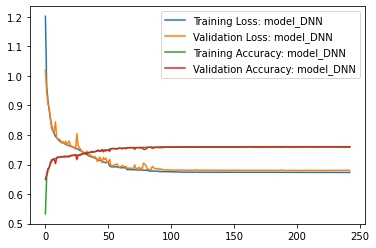

In [20]:
History(model.name, history)

# Exercise
Implement this mechanism to the starter notebook

# Challenge
Is the stopping too early? Explore "learning rate scheduling".